# Labelling ADRs using Data Programming Paradigm from Twitter Data

In [1]:
import pandas as pd
import pickle
import sys
sys.path.append('/Users/jarvis/Desktop/CODE/sadrat/')

from scrapers.helpers import Preprocessing

In [2]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
stop_list = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [3]:
#tqdm for estimating time taken for a task
from tqdm import tqdm_notebook

# Import Dataset
Having a look at the dataset

In [4]:
# As the input file is quite large, use dtype to specify the datatype of each column so that pandas doesn't need
# to find it out itself which is a memory intensive task.
df = pd.read_csv("/Users/jarvis/Desktop/CODE/sadrat/datasets/adrmine.csv")

In [5]:
df.shape

(965, 2)

In [6]:
df.head()

,tweet_id,tweet
0,3.446170e+17,"Vyvanse, commonly known as OCD in a pill."
1,3.446300e+17,@MTV When are you going to do True Life: I am ...
2,3.421170e+17,NEW post: how did my weekend go? What is anasa...
3,3.514470e+17,I wonder if seroquel /then/ food still equals ...
4,3.482630e+17,Rivaroxaban diary day 22. Last tablet taken Tu...


# The Problem Statement
(Writing the problem statement so that I don't forget the main intention of the task when the code gets bigger 😬).<br>
* Find and label ADR signals from the "text" column of the dataset using Data Programming(DP) paradigm. 
* Write different labelling functions using Snorkel framework and apply DP.
* Train and validate the model.

### Getting the dictionary of drugs and their known side effects scraped from drugs.com website.

In [7]:
with open("/Users/jarvis/Desktop/CODE/sadrat/datasets/drug_adr", "rb") as file:
    drugs = pickle.load(file)
file.close()

# Labeling Functions
We will write four labelling functions. (collaborators can add more labeling function after team discussion)
1. Sentiment Analysis - sentence polarities
2. Sentiment Analysis - sentence subjectivities
3. Distant Supervision
4. Simple ADR term matching

In [8]:
# defining constants for clarity
ADR = 1
ABSTAIN = -1
NOADR = 0

### Import Snorkel

In [9]:
from snorkel.labeling import labeling_function
from snorkel.preprocess import preprocessor
from textblob import TextBlob
import matplotlib.pyplot as plt

### LF1 and LF2: Sentiment Analysis

#### NOTE:
Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1]. <br>
**Hence a probable ADR must have low polarity and high subjectivity**

In [10]:
@preprocessor(memoize=True)
# type(x) - pandas Series
def textblob_sentiment(x):
    scores = TextBlob(x["tweet"])
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

In [11]:
comment_polarities = [textblob_sentiment(x).polarity for _, x in df.iterrows()]
comment_subjectivities = [textblob_sentiment(x).subjectivity for _, x in df.iterrows()]

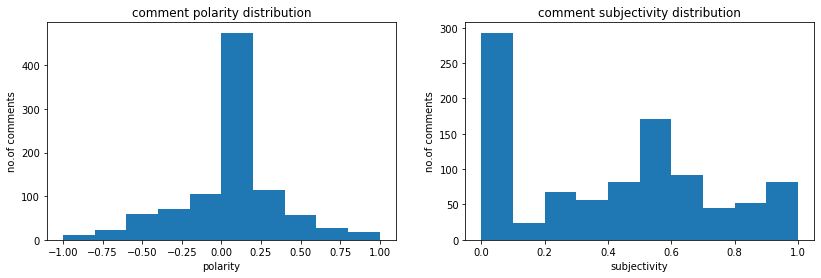

In [12]:
# plotting the data
plt.subplot(1,2,1)
plt.hist(comment_polarities, bins=10)
plt.title("comment polarity distribution")
plt.xlabel("polarity")
plt.ylabel("no.of comments")
plt.subplots_adjust(hspace=1, left=0.225, right=2, wspace=0.2)

plt.subplot(1,2,2)
plt.hist(comment_subjectivities, bins=10)
plt.title("comment subjectivity distribution")
plt.xlabel("subjectivity")
plt.ylabel("no.of comments")
# plt.savefig("sentiment_analysis2.png", bbox_inches="tight", dpi=300, pad_inches=0.1)
plt.show()

In [13]:
@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    return ADR if x.polarity < 0 else ABSTAIN

In [14]:
@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    return ADR if x.subjectivity > 0.6 else ABSTAIN

# LF3: Based on Known ADRs - Distant Supervision
Return 1 if ADR for the given drug is already known else return 0.<br>
Use the preprocessing function from helpers.py

### \# Semantic Similarity (used by LF2)
Finding the semantic similarity between the user comment and all the known adr for the particular drug

In [15]:
def semantic_similarity(comment):
    """
    @params: 
            type(comment): string
            
    credits: geeksforgeeks.org for some part of the below code
    https://www.geeksforgeeks.org/python-measure-similarity-between-two-sentences-using-cosine-similarity/
    """
    p = Preprocessing()
    extracted_drugs_list = list()
    known_adr = ""
    clean_comment = p.simple_preprocessor_string(comment)
    for word in clean_comment.split():
        if word.capitalize() in drugs.keys():
            extracted_drugs_list.append(word)
            for adr in drugs[word.capitalize()]:
                known_adr = known_adr + adr
        else:
            continue
#     print(known_adr)
    # clean the adr sentence
    known_adr = re.sub('[,-]','',known_adr)
    
    ### calculate cosine similarity between known_adr and clean_comment
    l1 = list()
    l2 = list()
    #tokenize the strings
    clean_comment_set = {x for x in word_tokenize(clean_comment)}
    known_adr_set = {x for x in word_tokenize(known_adr)}
    
    #form a set containing keywords of both strings
    rvec = clean_comment_set.union(known_adr_set)
    
    for w in rvec:
        if w in clean_comment_set:
            l1.append(1)
        else:
            l1.append(0)
        if w in known_adr_set:
            l2.append(1)
        else:
            l2.append(0)
    c = 0
    
    # cosine formula
    for i in range(len(rvec)):
        c = c + l1[i]*l2[i]
        
    if (sum(l1) and sum(l2)) != 0:
        cosine_similarity_score = c/float(sum(l1)*sum(l2)**0.5)
        return cosine_similarity_score
    else:
        return 0

### Test semantic_similarity()

In [16]:
#looking at a random tweet
print(df["tweet"][12], end = "\n")

Levaquin sucks. Blinding headaches. Vomiting. Diarrhea.

Time for my next dose.

Happy weekend.

#tmi #FML


In [17]:
# test semantic_similarity
print(semantic_similarity("Levaquin sucks. Blinding headaches. Vomiting. Diarrhea. Time for my next dose.Happy weekend."))

0.0


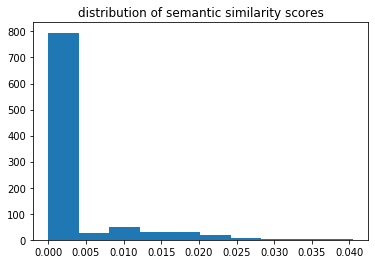

In [18]:
# plot semantic similarity over all datapoints
Y = list()
P = list()
for _, x in tqdm_notebook(df.iterrows()):
    Y.append(semantic_similarity(x["tweet"]))
    
plt.title("distribution of semantic similarity scores")
plt.hist(Y, bins = 10)
# plt.savefig("sentiment_analysis2.png", bbox_inches="tight", dpi=300, pad_inches=0.1)
plt.show()

In [19]:
@labeling_function()
def distant_supervision(x):
    """
    @params: type(x) - pandas series object
    """
    if semantic_similarity(x["tweet"]) == 0:
        return ABSTAIN
    else:
        return ADR

### LF 4: Look out for any mention of known ADR in the user comment
1. Make the Keyword space from the drug dictionary
2. Preprocess the user comment 
3. Use semantic similarity

In [20]:
# 1. Create Keywordspace
keywordspace = list()
for x in drugs.keys():
    for p in drugs[x]:
        for word in p.split():
            if word != "," and len(word) > 4 and word not in keywordspace:
                keywordspace.append(word)

In [21]:
def adr_term_matching(comment):
    """
    type(x): string
    """
    # preprocess x[" comment"]
    p = Preprocessing()
    clean_text = p.simple_preprocessor_string(comment)
    
    word_matches = 0
    for word in clean_text.split():
        if word in keywordspace:
            word_matches = word_matches + 1
        else:
            continue
    if word_matches != None:
        return word_matches
    else:
        return 0

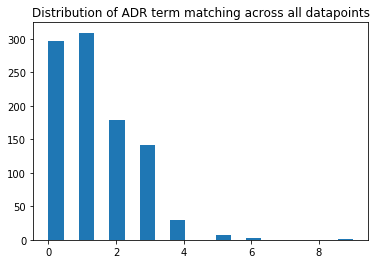

In [22]:
# plot distribution of adr word matches

X = list()
for _, x in tqdm_notebook(df.iterrows()):
    X.append(adr_term_matching(x["tweet"]))
plt.title("Distribution of ADR term matching across all datapoints")
plt.hist(X, bins = 20)
plt.show()

#### Asumption: 
Take matching score 0 as NOADR 1 as ABSTAIN and above 1 as ADR<br>
`again, this is just a guess and you can play with these thresholds to get a better labeling function`

In [23]:
@labeling_function()
def simple_term_matching(x):
    """
    type(x): pandas Series object
    """
    score = adr_term_matching(x["tweet"])
    if score != None:
        if score == 0 :
            return NOADR
        elif score == 1:
            return ABSTAIN
        elif score > 1:
            return ADR
    else:
        return ABSTAIN
    
    return ABSTAIN

## Apply LFs
#### Creating a test set and a training set
create a test set by manualy labelling the ADRs.

In [24]:
# TODO : manually anotate these datapoints.
df_test = df.sample(30, random_state=3)
df_test.head()

,tweet_id,tweet
637,3.514010e+17,Ah the sting of the #Humira injection. How I'v...
639,3.420490e+17,"You can have all the papers, articles etc abou..."
626,3.484580e+17,@VinnieMedugno come hangout by the pool
99,3.340240e+17,"*sanctifies mind* I'm fine. U? ""@BryteDude: @r..."
472,3.488620e+17,"Lunch: Carnita taco from new Taqueria, chicken..."


In [25]:
# make the training set
drop_index_list = list(df_test.index)
df_train = df.drop(drop_index_list)
df_train.shape

(935, 2)

In [39]:
for _,x in df_test.iterrows():
    print(x[0],x[1])
    print("")

3.51401e+17 Ah the sting of the #Humira injection. How I've not missed thee. #Ankylosing #Spondylitisq #Ouch

3.42049e+17 You can have all the papers, articles etc about #Pradaxa but until there is an antidote, this drug is a killer. #RECALLPRADAXA

3.48458e+17 @VinnieMedugno come hangout by the pool

3.34024e+17 *sanctifies mind* I'm fine. U? "@BryteDude: @remiamaka U said 'come again' and I said 'hand'. Belief is a thing of the mind. Howdy doc?"

3.48862e+17 Lunch: Carnita taco from new Taqueria, chicken soup, Ricola throat lozenge for dessert. Clearly trying to add stomach issues to the mix. O_o

3.40608e+17 @galaxiianxoxo Depression hurts, Cymbalta can help.

3.40562e+17 "@UberFacts: Bananas contain a natural chemical that can make a person happy - The same chemical found in Prozac." @CraigyAlford94 this too!

3.4886e+17 Comparison of 4 antipsychotics in patients over 40 with psychiatric disorders. quetiapine least safe http://1.usa.gov/14mFdY1ï¿½ @MedClerkships

3.46631e+17 "The d

In [41]:
manual_label_list = [0,1,0,0,0,0,0,1,0,0,1,1,0,1,1,1,0,1,0,0,1,0,1,1,0,1,0,0,0,0]

### Apply the LFs

In [42]:
from snorkel.labeling import PandasLFApplier
lfs = [textblob_polarity,
       textblob_subjectivity,
       distant_supervision,
       simple_term_matching
      ]
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)

/Users/jarvis/venvs/sadrat/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 935/935 [00:02<00:00, 416.07it/s]


### Evaluate Performance of LFs
#### 1. Coverage Check

In [43]:
coverage_textblob_polarity, coverage_textblob_subjectivity, coverage_distant_supervision,\
coverage_simple_term_matching = (L_train != ABSTAIN).mean(axis=0)
print(f"textblob_polarity coverage: {coverage_textblob_polarity * 100:.1f}%")
print(f"textblob_subjectivity coverage: {coverage_textblob_subjectivity * 100:.1f}%")
print(f"distant_supervision coverage: {coverage_distant_supervision * 100:.1f}%")
print(f"simple_term_matching coverage: {coverage_simple_term_matching * 100:.1f}%")

textblob_polarity coverage: 28.0%
textblob_subjectivity coverage: 27.9%
distant_supervision coverage: 17.5%
simple_term_matching coverage: 68.1%


#### Statistical Analysis of LFs

In [44]:
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
textblob_polarity,0,[1],0.280214,0.242781,0.068449
textblob_subjectivity,1,[1],0.279144,0.248128,0.089840
distant_supervision,2,[1],0.175401,0.145455,0.034225
simple_term_matching,3,"[0, 1]",0.681283,0.351872,0.144385


In [45]:
L_dev = applier.apply(df=df_test)

/Users/jarvis/venvs/sadrat/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 30/30 [00:00<00:00, 383.15it/s]


#### Checking Empirical Accuracy of different LFs

In [47]:
df_test["label"] = manual_label_list
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y=df_test.label.values)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
textblob_polarity,0,[1],0.300000,0.266667,0.033333,3,6,0.333333
textblob_subjectivity,1,[1],0.300000,0.300000,0.100000,4,5,0.444444
distant_supervision,2,[1],0.200000,0.166667,0.033333,3,3,0.500000
simple_term_matching,3,"[0, 1]",0.633333,0.333333,0.133333,9,10,0.473684


In [48]:
def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")

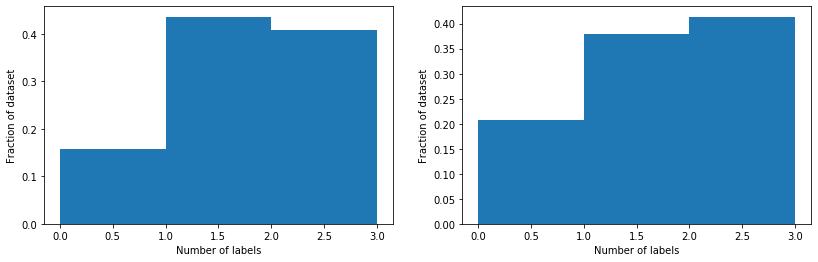

In [49]:
plt.subplot(1,2,1)
plot_label_frequency(L_train)
plt.subplots_adjust(hspace=1, left=0.225, right=2, wspace=0.2)
plt.subplot(1,2,2)
plot_label_frequency(L_dev)
plt.show()

More than 50% of the training dataset is labelled by 2-3 LFs and more than 70% of the test set is labelled by 2-3 LFs.<br>
Our goal is now to convert the labels from our LFs into a single _noise-aware_ probabilistic (or confidence-weighted) label per data point.
A simple baseline for doing this is to take the majority vote on a per-data point basis: if more LFs voted ADR than NOADR, label it ADR (and vice versa).
We can test this with the
[`MajorityLabelVoter` baseline model](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.MajorityLabelVoter.html#snorkel.labeling.MajorityLabelVoter).

In [50]:
from snorkel.labeling import MajorityLabelVoter

majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

In [51]:
preds_train

array([ 1,  1, -1,  1,  1,  1,  1,  0,  1,  1,  0, -1,  1,  1,  1,  0,  1,
       -1, -1,  1,  1,  1, -1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  0,  1,
        1,  1,  1,  0, -1,  1,  1, -1, -1,  1,  1,  0, -1,  1,  1,  1,  1,
        1, -1,  1, -1,  1, -1,  1,  1,  0,  0,  1, -1,  0,  1,  1,  1,  1,
        1,  1,  1,  1,  0,  0, -1,  1,  1, -1, -1,  0,  0,  1,  0,  1,  1,
        1,  1,  0, -1,  1,  1,  0,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1, -1,  0,  0, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
        0,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1, -1, -1, -1,  1,  1,
        1,  1,  0,  1,  1,  1,  0,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,
       -1, -1,  0, -1,  1,  1,  1,  1, -1,  0,  1, -1, -1,  1,  1,  1,  1,
        1,  1,  1, -1, -1,  0,  0,  1,  1,  1,  1,  1, -1,  0,  1, -1, -1,
        1,  1,  1,  1,  1, -1, -1,  1,  1,  1, -1,  1,  0,  1,  1, -1,  0,
        1,  0, -1,  1, -1,  1, -1,  1,  1,  1,  1,  0, -1,  1,  1,  1, -1,
        0,  0,  1,  1,  1

However, as we can clearly see by looking the summary statistics of our LFs, they are not all equally accurate, and should not be treated identically. In addition to having varied accuracies and coverages, LFs may be correlated, resulting in certain signals being overrepresented in a majority-vote-based model. To handle these issues appropriately, we will instead use a more sophisticated Snorkel `LabelModel` to combine the outputs of the LFs.

This model will ultimately produce a single set of noise-aware training labels, which are probabilistic or confidence-weighted labels. We will then use these labels to train a classifier for our task. For more technical details of this overall approach, see [NeurIPS 2016](https://arxiv.org/abs/1605.07723) and [AAAI 2019](https://arxiv.org/abs/1810.02840) papers. For more info on the API, see the [`LabelModel` documentation](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.LabelModel.html#snorkel.labeling.LabelModel).

Note that no gold labels are used during the training process.
The only information we need is the label matrix, which contains the output of the LFs on our training set.
The `LabelModel` is able to learn weights for the labeling functions using only the label matrix as input.
We also specify the `cardinality`, or number of classes.
The `LabelModel` trains much more quickly than typical discriminative models since we only need the label matrix as input.

In [52]:
from snorkel.labeling import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=1000, lr=0.001, log_freq=100, seed=123)

In [53]:
majority_acc = majority_model.score(L=L_dev, Y=df_test.label.values)["accuracy"]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_dev, Y=df_test.label.values)["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   42.9%
Label Model Accuracy:     45.8%


Let's briefly confirm that the labels the `LabelModel` produces are probabilistic in nature.
The following histogram shows the confidences we have that each data point has the label SPAM.
The points we are least certain about will have labels close to 0.5.

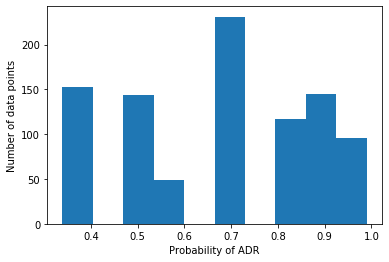

In [55]:
def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of ADR")
    plt.ylabel("Number of data points")
    plt.savefig("prob_adr.png", bbox_inches="tight", dpi=300, pad_inches=0.1)
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, ADR])

### Filtering out unlabeled data points
As we saw earlier, some of the data points in our `train` set received no labels from any of our LFs.
These data points convey no supervision signal and tend to hurt performance, so we filter them out before training using a
[built-in utility](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.filter_unlabeled_dataframe.html#snorkel.labeling.filter_unlabeled_dataframe).

In [56]:
from snorkel.labeling import filter_unlabeled_dataframe

df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

## Training a Classifier

Now we'll use the noisy training labels we generated in the last section to train a classifier for our task.
**The output of the Snorkel `LabelModel` is just a set of labels which can be used with most popular libraries for performing supervised learning, such as TensorFlow, Keras, PyTorch, Scikit-Learn, Ludwig, and XGBoost etc.**
In this tutorial, we demonstrate using classifiers from [Keras](https://keras.io) and [Scikit-Learn](https://scikit-learn.org).

## Featurization

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1,2))
X_train = vectorizer.fit_transform(df_train_filtered["tweet"].tolist())
X_test = vectorizer.transform(df_test["tweet"].tolist())

### Scikit-Learn with Rounded Labels

If we want to use a library or model that doesn't accept probabilistic labels, we can replace each label distribution with the label of the class that has the maximum probability.
This can easily be done using the
[`probs_to_preds` helper method](https://snorkel.readthedocs.io/en/master/packages/_autosummary/utils/snorkel.utils.probs_to_preds.html#snorkel.utils.probs_to_preds).
It's important to note that this transformation is lossy, as we no longer have values for our confidence in each label.

In [61]:
from snorkel.utils import probs_to_preds

preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

This allows us to use standard models of scikit-learn

In [62]:
from sklearn.linear_model import LogisticRegression

sklearn_model = LogisticRegression(C=0.001, solver="liblinear")
sklearn_model.fit(X=X_train, y=preds_train_filtered)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [63]:
Y_test = df_test["label"].values
print(f"Test Accuracy: {sklearn_model.score(X=X_test, y=Y_test) * 100:.1f}%")

Test Accuracy: 40.0%


In [79]:
predictions = sklearn_model.fit(X=X_train, y=preds_train_filtered)

### Save to disk as joblib file

In [77]:
from joblib import dump

In [ ]:
def prediction_job(input_data):
    """@params: type(input_data): 2D matrix"""
    return sklearn_model.predict(X=input_data)

<791x9108 sparse matrix of type '<class 'numpy.float64'>'
	with 14310 stored elements in Compressed Sparse Row format>